In [1]:
import glob

glob.glob("./split_samples/*/*.csv")[0].split("\\")[1]

IndexError: list index out of range

In [ ]:
from inception import Inception, InceptionBlock
import torch.nn as nn

class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)
	
InceptionTime = nn.Sequential(
                Reshape(out_shape=(1,160)),
                InceptionBlock(
                    in_channels=1, 
                    n_filters=32, 
                    kernel_sizes=[5, 11, 23],
                    bottleneck_channels=32,
                    use_residual=True,
                    activation=nn.ReLU()
                ),
                InceptionBlock(
                    in_channels=32*4, 
                    n_filters=32, 
                    kernel_sizes=[5, 11, 23],
                    bottleneck_channels=32,
                    use_residual=True,
                    activation=nn.ReLU()
                ),
                nn.AdaptiveAvgPool1d(output_size=1),
                Flatten(out_features=32*4*1),
                nn.Linear(in_features=4*32*1, out_features=3)
    )

In [4]:
from datatset import DROZY_FACE_Dataset
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms, models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# 데이터 전처리 (MobileNetV3에 맞게, 1채널 입력을 위한 Normalize 값 수정)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전 증강
    transforms.RandomRotation(degrees=10),   # 회전 증강
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 밝기/대비/채도/색조 증강
    transforms.Normalize([0.5], [0.5])  # 1채널(흑백) 이미지에 맞는 정규화
])

# DROZY_FACE_Dataset이 transform 인자를 받도록 datatset.py에서 수정 필요
train_dataset = DROZY_FACE_Dataset(split_dir="./output_npy/train", transform=transform)
test_dataset = DROZY_FACE_Dataset(split_dir="./output_npy/test")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MobileNetV3 모델 불러오기
mobilenet_v3 = models.mobilenet_v3_small(pretrained=True)
# 첫 번째 conv 레이어를 1채널 입력에 맞게 수정
mobilenet_v3.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=mobilenet_v3.features[0][0].out_channels,
    kernel_size=mobilenet_v3.features[0][0].kernel_size,
    stride=mobilenet_v3.features[0][0].stride,
    padding=mobilenet_v3.features[0][0].padding,
    bias=False
)
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v3 = mobilenet_v3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v3.parameters(), lr=1e-4)

# 학습 루프
from tqdm import tqdm

num_epochs = 5
for epoch in range(num_epochs):
    mobilenet_v3.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels, _ in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_v3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # tqdm 진행바에 현재 loss와 acc 표시
        current_loss = running_loss / total if total > 0 else 0
        current_acc = correct / total * 100 if total > 0 else 0
        pbar.set_postfix({'loss': f'{current_loss:.4f}', 'acc': f'{current_acc:.2f}%'})
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%")

    # 테스트 코드 추가
    mobilenet_v3.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        pbar_test = tqdm(test_dataloader, desc="테스트 진행중")
        for images, labels, _ in pbar_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = mobilenet_v3(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            current_test_loss = test_loss / test_total if test_total > 0 else 0
            current_test_acc = test_correct / test_total * 100 if test_total > 0 else 0
            pbar_test.set_postfix({'loss': f'{current_test_loss:.4f}', 'acc': f'{current_test_acc:.2f}%'})
        test_epoch_loss = test_loss / test_total
        test_epoch_acc = test_correct / test_total * 100
        print(f"테스트 Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.2f}%")

Epoch [1/5]:   0%|          | 28/6021 [00:09<32:56,  3.03it/s, loss=1.1536, acc=36.38%]


KeyboardInterrupt: 

In [13]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

## Signal

In [8]:
from datatset import DROZY_EYELANDMARK_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/test")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

import torch
import torch.nn as nn
import torch.optim as optim
from importlib import import_module

ResNet1D = getattr(import_module("1dresnet"), "ResNet1D")
def check_batch(rrsp_bpm, kss_label, sample_path):
    # sample_path는 rrsp_bpm, kss_label과 순서가 대응되는 path의 리스트임
    if not torch.isfinite(rrsp_bpm).all():
        idxs = (~torch.isfinite(rrsp_bpm)).any(dim=1) if rrsp_bpm.dim() > 1 else ~torch.isfinite(rrsp_bpm)
        for i in torch.where(idxs)[0]:
            print(f"[!] rrsp_bpm 이상치 있음 - sample_path: {sample_path[i]}")
    if not torch.isfinite(kss_label).all():
        idxs = ~torch.isfinite(kss_label)
        for i in torch.where(idxs)[0]:
            print(f"[!] label 이상치 있음 - sample_path: {sample_path[i]}")
# rrsp_bpm의 shape: (batch, 96, 600)z
# 96: feature 개수, 600: 프레임 개수
# Conv1d의 in_channels=feature 개수(96), seq_len=600
class RRSP_1DCNN(nn.Module):
    def __init__(self, num_classes=3, input_size=96):
        super(RRSP_1DCNN, self).__init__()
        # 입력: (batch, 96, 600)
        # Conv1d 입력: (batch, in_channels=96, seq_len=600)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (batch, channel, 1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, 96, 600)
        # 만약 x가 (batch, 96, 600)이 아니고 (batch, 600, 96)이면 permute 필요
        if x.shape[1] != 96:
            # (batch, 600, 96) -> (batch, 96, 600)
            x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.global_pool(x)  # (batch, channel, 1)
        x = x.squeeze(-1)        # (batch, channel)
        x = self.fc(x)           # (batch, num_classes)
        return x

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRSP_1DCNN(num_classes=3, input_size=96).to(device)
model = model.float()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    loss_list = []
    pbar = tqdm(train_dataloader)
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    for rrsp_bpm, kss_label, sample_path in pbar:
        # nan이 포함된 배치는 건너뜀

        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        
        optimizer.zero_grad()
        outputs = model(rrsp_bpm)
        loss = criterion(outputs, kss_label)
        check_batch(rrsp_bpm, kss_label, sample_path)

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        avg_loss = sum(loss_list) / len(loss_list)
        pbar.set_postfix(loss=avg_loss)

    # 검증
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        pbar.set_description("테스트 진행중")
        for rrsp_bpm, kss_label,sample_path in pbar:
            rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
            kss_label = kss_label.to(device)
            outputs = model(rrsp_bpm)
            check_batch(rrsp_bpm, kss_label, sample_path)

            _, predicted = torch.max(outputs, 1)
            total += kss_label.size(0)
            correct += (predicted == kss_label).sum().item()
            acc = correct / total * 100
            pbar.set_postfix(acc=f"{acc:.2f}%")
    print(f"테스트 정확도: {acc:.2f}%")


테스트 진행중: 100%|██████████| 144/144 [10:26<00:00,  4.35s/it, acc=46.49%]


테스트 정확도: 46.49%


테스트 진행중: 100%|██████████| 144/144 [11:10<00:00,  4.66s/it, acc=39.10%]


테스트 정확도: 39.10%


테스트 진행중: 100%|██████████| 144/144 [10:34<00:00,  4.41s/it, acc=39.42%]


테스트 정확도: 39.42%


테스트 진행중: 100%|██████████| 144/144 [10:22<00:00,  4.33s/it, acc=57.17%]


테스트 정확도: 57.17%


테스트 진행중: 100%|██████████| 144/144 [10:59<00:00,  4.58s/it, acc=23.87%]


테스트 정확도: 23.87%


테스트 진행중: 100%|██████████| 144/144 [11:48<00:00,  4.92s/it, acc=47.58%]


테스트 정확도: 47.58%


테스트 진행중: 100%|██████████| 144/144 [10:32<00:00,  4.39s/it, acc=47.68%]


테스트 정확도: 47.68%


테스트 진행중: 100%|██████████| 144/144 [10:36<00:00,  4.42s/it, acc=52.07%]


테스트 정확도: 52.07%


테스트 진행중: 100%|██████████| 144/144 [10:28<00:00,  4.36s/it, acc=53.08%]


테스트 정확도: 53.08%


테스트 진행중: 100%|██████████| 144/144 [12:38<00:00,  5.27s/it, acc=58.07%]

테스트 정확도: 58.07%


In [1]:
from torch.utils.data import DataLoader
from tqdm import trange
from datatset import DROZY_EYELANDMARK_Dataset
train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/test")

bad_indices = []
for i in trange(len(train_dataset)):
    try:
        rrsp_bpm, kss_label = train_dataset[i]
        if rrsp_bpm.numel() == 0 or kss_label.numel() == 0:
            print(f"문제 있는 샘플 발견: {i}")
            bad_indices.append((i, rrsp_bpm.shape, kss_label.shape))
    except Exception as e:
        bad_indices.append((i, "Exception", str(e)))

print(f"총 {len(bad_indices)}개의 문제 있는 샘플 발견:")
for idx, rrsp_shape, kss_shape in bad_indices:
    print(f"  - Index {idx}: rrsp_bpm shape = {rrsp_shape}, kss_label shape = {kss_shape}")


100%|██████████| 13754/13754 [12:27<00:00, 18.40it/s]

총 0개의 문제 있는 샘플 발견:


In [10]:

model.eval()
correct = 0
total = 0
with torch.no_grad():
    pbar = tqdm(train_dataloader)
    pbar.set_description("테스트 진행중")
    for rrsp_bpm, kss_label in pbar:
        # 텐서에 nan이 포함되어 있으면 해당 배치는 건너뜀
        # if torch.isnan(rrsp_bpm).any() or torch.isnan(kss_label).any():
        #     continue
        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        # outputs에 nan이 포함되어 있으면 건너뜀
        # if torch.isnan(outputs).any():
        #     continue
        _, predicted = torch.max(outputs, 1)
        total += kss_label.size(0)
        correct += (predicted == kss_label).sum().item()
        acc = correct / total * 100
        pbar.set_postfix(acc=f"{acc:.2f}%")

테스트 진행중:   4%|▎         | 8/216 [00:23<10:11,  2.94s/it, acc=30.66%]


KeyboardInterrupt: 

In [9]:
acc

29.83133061404476

In [6]:
from datatset import DROZY_EYELANDMARK_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/test")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

for data in tqdm(train_dataloader):
    pass  # 모든 학습 데이터 순회


  3%|▎         | 6/215 [00:28<16:41,  4.79s/it]


KeyboardInterrupt: 

In [ ]:
test_data

(tensor([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
          9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 10.,
         10., 10., 10., 10., 10., 11., 11., 11., 11., 11., 12., 12., 12., 13.,
         13., 13., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
         14., 15., 15., 15., 15., 15., 15., 15., 16., 16., 16., 16., 16., 16.,
         16., 16., 17., 17., 17., 17., 17., 17., 17., 17., 18., 18., 18., 18.,
         18., 18., 18., 19., 19., 19., 19., 19., 19., 19., 19., 19., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21.

In [2]:
from datatset import DROZY_RRSP_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_RRSP_Dataset(split_dir="./split_samples/train")
test_dataset = DROZY_RRSP_Dataset(split_dir="./split_samples/test")

for test_data in train_dataset:
    pass

sample_path 에서 에러 발생: ./split_samples/train\1-2\sample_00165.csv


KeyError: 'rrsp_bpm_final'

테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.80it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.00it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 16.12it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 16.08it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.51it/s, acc=45.45%]

테스트 정확도: 45.45%


In [9]:
total, correct

(6335, 2879)

Epoch [1/5]:   0%|          | 0/222 [00:00<?, ?it/s]


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동행렬 계산 및 시각화
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for rrsp_bpm, kss_label in test_dataloader:
        rrsp_bpm = rrsp_bpm.to(device)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(kss_label.cpu().numpy())



NameError: name 'plt' is not defined

테스트 진행중: 100%|██████████| 139/139 [04:23<00:00,  1.89s/it, acc=48.52%]


테스트 정확도: 48.52%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=56.76%]


테스트 정확도: 56.76%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=33.06%]


테스트 정확도: 33.06%


테스트 진행중: 100%|██████████| 139/139 [04:19<00:00,  1.87s/it, acc=51.09%]


테스트 정확도: 51.09%


테스트 진행중: 100%|██████████| 139/139 [04:20<00:00,  1.87s/it, acc=61.50%]


테스트 정확도: 61.50%


테스트 진행중: 100%|██████████| 139/139 [04:20<00:00,  1.87s/it, acc=52.91%]


테스트 정확도: 52.91%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=45.10%]


테스트 정확도: 45.10%


테스트 진행중: 100%|██████████| 139/139 [04:17<00:00,  1.85s/it, acc=56.67%]


테스트 정확도: 56.67%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=60.40%]


테스트 정확도: 60.40%


테스트 진행중: 100%|██████████| 139/139 [04:19<00:00,  1.87s/it, acc=61.50%]

테스트 정확도: 61.50%


c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\

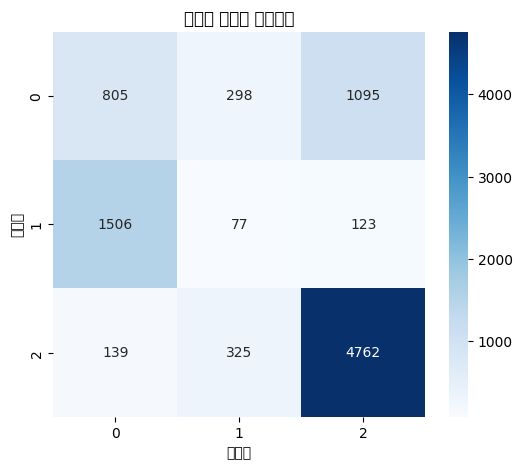

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 테스트 데이터 전체 예측값과 실제값을 저장할 리스트
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for rrsp_bpm, kss_label in test_dataloader:
        if torch.isnan(rrsp_bpm).any() or torch.isnan(kss_label).any():
            continue
        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        if torch.isnan(outputs).any():
            continue
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(kss_label.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("테스트 데이터 혼동행렬")
plt.show()


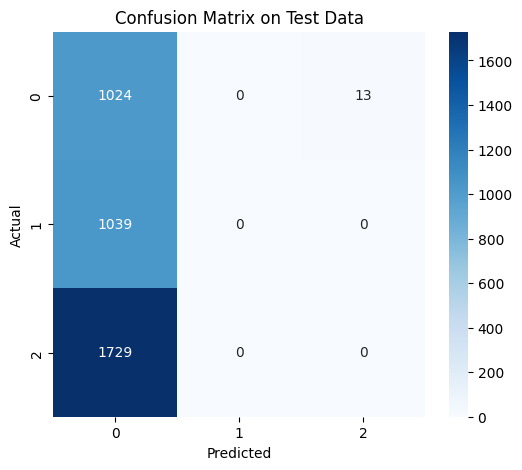

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

In [ ]:


model = ResNet1D(
    in_channels=96,
    base_filters=16,
    kernel_size=7,
    stride=1,
    groups=1,
    n_block=5,
    n_classes=3,
    downsample_gap=2,
    increasefilter_gap=4,
    use_bn=True,
    use_do=True,
    verbose=False
)

In [5]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

NameError: name 'confusion_matrix' is not defined

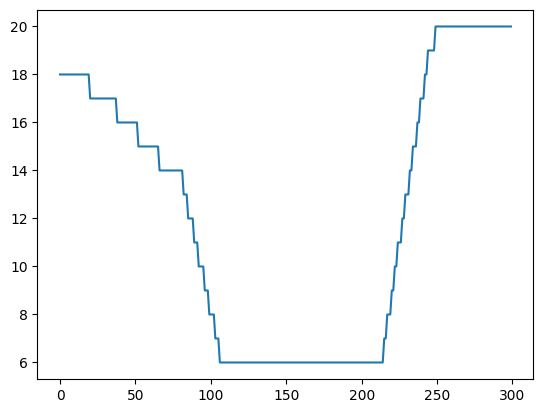

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./split_samples/train/1-1/sample_00630.csv"
df = pd.read_csv(file_path)

# rrsp_bpm_final 컬럼만 추출하여 리스트로 변환
rrsp_bpm_list = df['rrsp_bpm_final'].tolist()

plt.plot(rrsp_bpm_list)
plt.show()

In [16]:
kss_path = "./DROZY/KSS.txt"
kss_dict = {}
key_list = []
for i in range(1, 15):
    for j in range(1, 4):
        key_list.append(f"{i}-{j}")

with open(kss_path, 'r') as f:
    kss_values = []
    for line in f:
        kss_values.extend(line.strip().split())

# KSS 값을 1~3은 0, 4~6은 1, 7~9는 3으로 치환
def map_kss_value(val):
    v = int(val)
    if 1 <= v <= 3:
        return 0
    elif 4 <= v <= 6:
        return 1
    elif 7 <= v <= 9:
        return 3
    else:
        return v  # 혹시 모를 예외 처리

for idx, key in enumerate(key_list):
    kss_dict[key] = map_kss_value(kss_values[idx])

In [17]:
kss_dict

{'1-1': 0,
 '1-2': 1,
 '1-3': 3,
 '2-1': 0,
 '2-2': 3,
 '2-3': 1,
 '3-1': 0,
 '3-2': 0,
 '3-3': 1,
 '4-1': 1,
 '4-2': 3,
 '4-3': 3,
 '5-1': 0,
 '5-2': 3,
 '5-3': 3,
 '6-1': 0,
 '6-2': 0,
 '6-3': 3,
 '7-1': 0,
 '7-2': 1,
 '7-3': 3,
 '8-1': 0,
 '8-2': 1,
 '8-3': 3,
 '9-1': 0,
 '9-2': 1,
 '9-3': 3,
 '10-1': 0,
 '10-2': 1,
 '10-3': 3,
 '11-1': 1,
 '11-2': 3,
 '11-3': 3,
 '12-1': 0,
 '12-2': 1,
 '12-3': 1,
 '13-1': 1,
 '13-2': 0,
 '13-3': 3,
 '14-1': 1,
 '14-2': 3,
 '14-3': 3}

### 신호 데이터 확인

In [ ]:
# import pandas as pd
# # import numpy as np
# # import cv2

# # # CSV 파일 경로
# # df_path = "G:/DROZY_signals/split_eye_landmark/train/5-2/sample_00300.csv"
# # df = pd.read_csv(df_path)

# # # 전체 프레임 수
# # num_frames = len(df)

# # # 랜드마크 키 추출
# # landmark_keys = sorted(set(col[:-2] for col in df.columns if col.endswith("_x")))

# # # 프레임 사이즈 키우기
# # canvas_size = (1024, 1024)

# # frame_index = 0
# # while True:
# #     # 흰색 배경 캔버스
# #     canvas = np.ones((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) * 255

# #     frame = df.iloc[frame_index]
# #     for i, key in enumerate(landmark_keys):
# #         x = int(frame[f"{key}_x"] * canvas_size[0])
# #         y = int(frame[f"{key}_y"] * canvas_size[1])
# #         cv2.circle(canvas, (x, y), 6, (255, 0, 0), -1)  # 점 크게
# #         cv2.putText(canvas, str(i), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# #     cv2.putText(canvas, f"Frame {frame_index}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
# #     cv2.imshow("Landmark Viewer", canvas)

# #     key = cv2.waitKey(0) & 0xFF
# #     if key == ord('d'):
# #         frame_index += 1
# #         if frame_index >= num_frames:
# #             print("마지막 프레임입니다.")
# #             break
# #     elif key == ord('q'):
# #         print("종료합니다.")
# #         break

# # cv2.destroyAllWindows()


In [15]:
import pandas as pd
import glob
import concurrent.futures
from tqdm import tqdm

csv_paths = glob.glob("G:/DROZY_signals/split_eye_landmark/test/*/*.csv")
nan_file_list = []

def check_nan(path):
    try:
        df = pd.read_csv(path)
        if df.isnull().values.any():
            return path
    except Exception as e:
        print(f"파일 읽기 오류: {path}, 에러: {e}")
    return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(check_nan, csv_paths), total=len(csv_paths), desc="NaN 검사 중"))

nan_file_list = [r for r in results if r is not None]

print("NaN 값이 있는 파일 목록:")
for file in nan_file_list:
    print(file)


NaN 검사 중: 100%|██████████| 9167/9167 [01:45<00:00, 86.79it/s] 

NaN 값이 있는 파일 목록:


In [16]:
nan_file_list

[]

In [11]:
!pip install send2trash

In [17]:
from send2trash import send2trash
import os

trash_dir = "G:/DROZY_signals/split_eye_landmark/trashbin"
os.makedirs(trash_dir, exist_ok=True)

for file_path in nan_file_list:
    try:
        file_name = os.path.basename(file_path)
        dest_path = os.path.join(trash_dir, file_name)
        os.rename(file_path, dest_path)
        print(f"{file_path} → {dest_path}로 이동 완료")
    except Exception as e:
        print(f"{file_path} 이동 실패: {e}")
